重新写预处理操作，数据集不大，转为numpy文件就行。要不然每次读取图片太慢了，GPU利用率也不高

In [2]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
origin_dir = './origin_datasets'
datasets_dir = './datasets'
dataset = 'ISIC'

In [3]:
origin_dataset = os.path.join(origin_dir,dataset)
target_dataset = os.path.join(datasets_dir,dataset)
print(origin_dataset,target_dataset)

./origin_datasets/ISIC ./datasets/ISIC


In [4]:
if not os.path.exists(target_dataset):
    os.makedirs(target_dataset)
if not os.path.exists(os.path.join(target_dataset,'images')):
    os.makedirs(os.path.join(target_dataset,'images'))    
if not os.path.exists(os.path.join(target_dataset,'masks')):
    os.makedirs(os.path.join(target_dataset,'masks'))

In [5]:
# Data loading code
img_ids = glob(os.path.join(origin_dataset, 'images', '*'))
img_ids[0]

'./origin_datasets/ISIC/images/ISIC_0016057.jpg'

In [6]:
mask_ids = []
for img_id in img_ids:
    img_name = img_id.split('/')[-1].split('.')[0] # ISIC_0008256
    mask_ids.append(os.path.join(origin_dataset, 'masks', '0', img_name+'_segmentation.png'))
print(img_ids[64],mask_ids[64])

./origin_datasets/ISIC/images/ISIC_0000388.jpg ./origin_datasets/ISIC/masks/0/ISIC_0000388_segmentation.png


## process

做归一化，也做resize

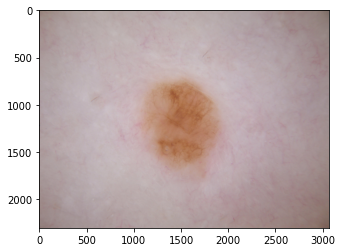

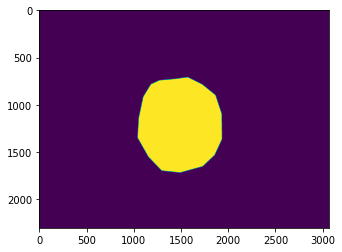

(2304, 3072, 3) (2304, 3072) 216 48 1.0 0.0


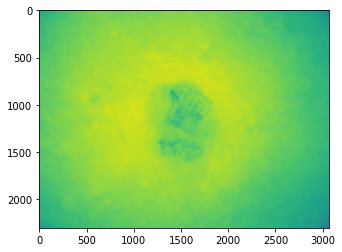

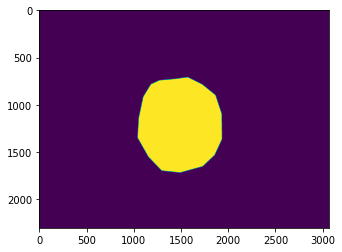

(3, 2304, 3072) (1, 2304, 3072) 0.8470588235294118 0.18823529411764706 1.0 0.0


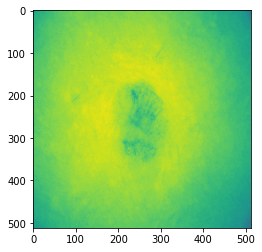

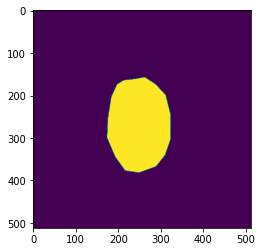

(3, 512, 512) (1, 512, 512) 0.83186275 0.20049019 1.0 0.0


In [7]:
img = plt.imread(img_ids[64])
plt.imshow(img)
plt.show()

mask = plt.imread(mask_ids[64])
plt.imshow(mask)
plt.show()

print( img.shape,mask.shape,img.max(),img.min(),mask.max(),mask.min() )

img = img.transpose(2,0,1)/255.0
H,W = mask.shape
mask = mask.reshape(1,H,W)

plt.imshow(img[0])
plt.show()

plt.imshow(mask[0])
plt.show()
print( img.shape,mask.shape,img.max(),img.min(),mask.max(),mask.min() )


upsample = nn.Upsample(size=(512), mode='bilinear',align_corners=False)
img,mask = torch.Tensor(img).unsqueeze(0),torch.Tensor(mask).unsqueeze(0)
img,mask = upsample(img).squeeze(0).numpy(),upsample(mask).squeeze(0).numpy()

plt.imshow(img[0])
plt.show()

plt.imshow(mask[0])
plt.show()
print( img.shape,mask.shape,img.max(),img.min(),mask.max(),mask.min() )

In [8]:
from tqdm import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
## 这么慢么？？？？？？不应该啊 1h09min 没有resize之前是这么慢，resize到512之后是25min
upsample = nn.Upsample(size=(512), mode='bilinear',align_corners=False)

for index,img_id in enumerate(tqdm(img_ids)):
    img_name = img_id.split('/')[-1].split('.')[0] # ISIC_0008256
    img = plt.imread(img_id)
    mask = plt.imread(mask_ids[index])
    

    img = img.transpose(2,0,1)/255.0     # 归一化
    H,W = mask.shape
    mask = mask.reshape(1,H,W)      # 加维度
    
    # resize
    img,mask = torch.Tensor(img).unsqueeze(0),torch.Tensor(mask).unsqueeze(0)
    img,mask = upsample(img).squeeze(0).numpy(),upsample(mask).squeeze(0).numpy()
    
    # save
    np.save(os.path.join(target_dataset,'images',img_name+'.npy'),img)
    np.save(os.path.join(target_dataset,'masks',img_name+'.npy'),mask)

100%|██████████| 2594/2594 [37:24<00:00,  1.16it/s]  


In [9]:
img_names = []
for index,img_id in enumerate(tqdm(img_ids)):
    img_name = img_id.split('/')[-1].split('.')[0] # ISIC_0008256
    img_names.append(img_name+'.npy')
img_names = np.array(img_names)
np.save(os.path.join(target_dataset,'img_names'),img_names)

100%|██████████| 2594/2594 [00:00<00:00, 511447.59it/s]


## result目录

In [10]:
if not os.path.exists('./result'):
    os.makedirs('./result')

In [11]:
img_names = np.load(os.path.join(target_dataset,'img_names.npy'))
img_names

array(['ISIC_0016057.npy', 'ISIC_0013302.npy', 'ISIC_0013459.npy', ...,
       'ISIC_0012211.npy', 'ISIC_0014922.npy', 'ISIC_0012149.npy'],
      dtype='<U16')

In [12]:
len(img_names)

2594

In [15]:
img_names = np.load(os.path.join('./datasets','ISIC','img_names.npy'))
from sklearn.model_selection import train_test_split
train_img_ids, valid_img_ids = train_test_split(img_names, test_size=0.2,shuffle=True,random_state=41)

In [19]:
target_dataset

'./datasets/ISIC'

In [21]:
np.save(os.path.join(target_dataset,'train_img_ids.npy'),train_img_ids)
np.save(os.path.join(target_dataset,'valid_img_ids.npy'),valid_img_ids)

# 检查一下

In [4]:
train_img_ids = np.load(os.path.join('./datasets','ISIC','train_img_ids.npy'))
valid_img_ids = np.load(os.path.join('./datasets','ISIC','valid_img_ids.npy'))

In [6]:
train_img_ids[0]

'ISIC_0000105.npy'

In [16]:
train_sample_img = np.load(os.path.join('./datasets','ISIC','images',train_img_ids[0]))
train_sample_mask = np.load(os.path.join('./datasets','ISIC','masks',train_img_ids[0]))

In [17]:
train_sample_img.shape,train_sample_mask.shape

((3, 512, 512), (1, 512, 512))

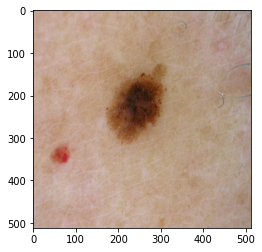

(None, 0.99610233, 0.00021637563)

In [13]:
import matplotlib.pyplot as plt
plt.imshow(train_sample_img.transpose(1,2,0))
plt.show(),train_sample_img.max(),train_sample_img.min()

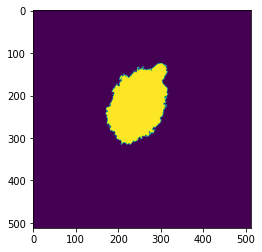

(None, 1.0, 0.0)

In [18]:
plt.imshow(train_sample_mask.transpose(1,2,0))
plt.show(),train_sample_mask.max(),train_sample_mask.min()

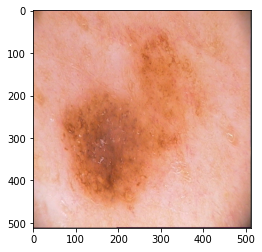

(None, 1.0, 0.0)

In [20]:
valid_sample_img = np.load(os.path.join('./datasets','ISIC','images',valid_img_ids[0]))
valid_sample_mask = np.load(os.path.join('./datasets','ISIC','masks',valid_img_ids[0]))
import matplotlib.pyplot as plt
plt.imshow(valid_sample_img.transpose(1,2,0))
plt.show(),valid_sample_img.max(),valid_sample_img.min()

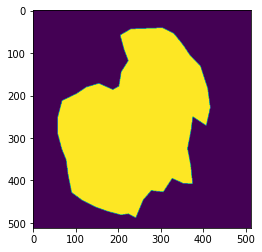

(None, 1.0, 0.0)

In [21]:
plt.imshow(valid_sample_mask.transpose(1,2,0))
plt.show(),valid_sample_mask.max(),valid_sample_mask.min()